In [47]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
from functools import partial
import os
import pickle as pkl
from collections.abc import MutableMapping

import matplotlib.pyplot as plt
import numpy as np
import tqdm

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["DDE_BACKEND"] = "jax"

# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".XX"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"]="platform"

from jax import config
config.update("jax_enable_x64", True)
# config.update("jax_debug_nans", True)

import jax
import jax.numpy as jnp
import flax
from flax import linen as nn
import optax

# print(f'Jax: CPUs={jax.local_device_count("cpu")} - GPUs={jax.local_device_count("gpu")}')

from deepxde_al_patch import deepxde as dde

from deepxde_al_patch.model_loader import construct_model
from deepxde_al_patch.modified_train_loop import ModifiedTrainLoop
from deepxde_al_patch.plotters import plot_residue_loss, plot_error, plot_prediction
from deepxde_al_patch.train_set_loader import load_data

from deepxde_al_patch.ntk import NTKHelper
from deepxde_al_patch.utils import get_pde_residue, print_dict_structure

In [49]:
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 300

plt.rcParams.update({
    'font.size': 12,
    'text.usetex': False,
})

In [50]:
BURGERS_1D_SIMILAR_SEEDS = [
#     (31, 47),
#     (76, 219),
#     (291, 857),
#     (219, 558),
#     (28, 346),
#     (568, 883),
#     (172, 376),
#     (172, 637),
#     (464, 566),
#     (219, 745),
#     (28, 82),
#     (69, 376),
#     (76, 745),
#     (92, 986),
#     (223, 981),
#     (536, 879),
#     (558, 745),
#     (376, 511),
#     (2, 276),
#     (88, 642),
#     (472, 978),
#     (376, 983),
#     (364, 925),
#     (172, 377),
    (76, 558),
    (242, 637),
#     (69, 511),
#     (628, 859),
#     (511, 983),
#     (53, 867)
]

In [51]:
seed_idx_pair = 1

In [52]:
model_common_params = dict(
    
    pde_name='burgers-1d', 
    pde_const=(0.02,), 
    use_pdebench=True,
    data_root=str(os.getcwd()) + '/pdebench',
    
    # model params
    hidden_layers=4, 
    hidden_dim=64, 
    activation='tanh', 
    initializer='Glorot uniform', 
    arch=None, 
    
)

data_code = f'{model_common_params["pde_name"]}-{model_common_params["pde_const"][0]}'
model_code = f'{model_common_params["arch"]}-{model_common_params["hidden_layers"]}-{model_common_params["hidden_dim"]}'
param_prefix = f'{data_code}_pb-{BURGERS_1D_SIMILAR_SEEDS[seed_idx_pair][0]}_{model_code}_v0'

## Setup

In [53]:
print(os.getcwd())

model, model_aux = construct_model(
    data_seed=BURGERS_1D_SIMILAR_SEEDS[seed_idx_pair][0],
    num_domain=1000, 
    num_boundary=200, 
    num_initial=200,
    **model_common_params
)

/Users/moritzhauschulz/oxford_code/tdl/tdl_mini_project/pinnacle_code
Compiling model...
'compile' took 0.082553 s



In [54]:
train_loop = ModifiedTrainLoop(
    model=model, 
    point_selector_method='random',
    point_selector_args=dict(res_proportion=0.7),
    
    train_steps=50000,
    al_every=50000,
    select_anchors_every=50000,
    mem_pts_total_budget=10000,
    anchor_budget=1000,
    snapshot_every=5000,
    optim_method='adam', 
    optim_lr=1e-4, 
    optim_args=dict(),
)

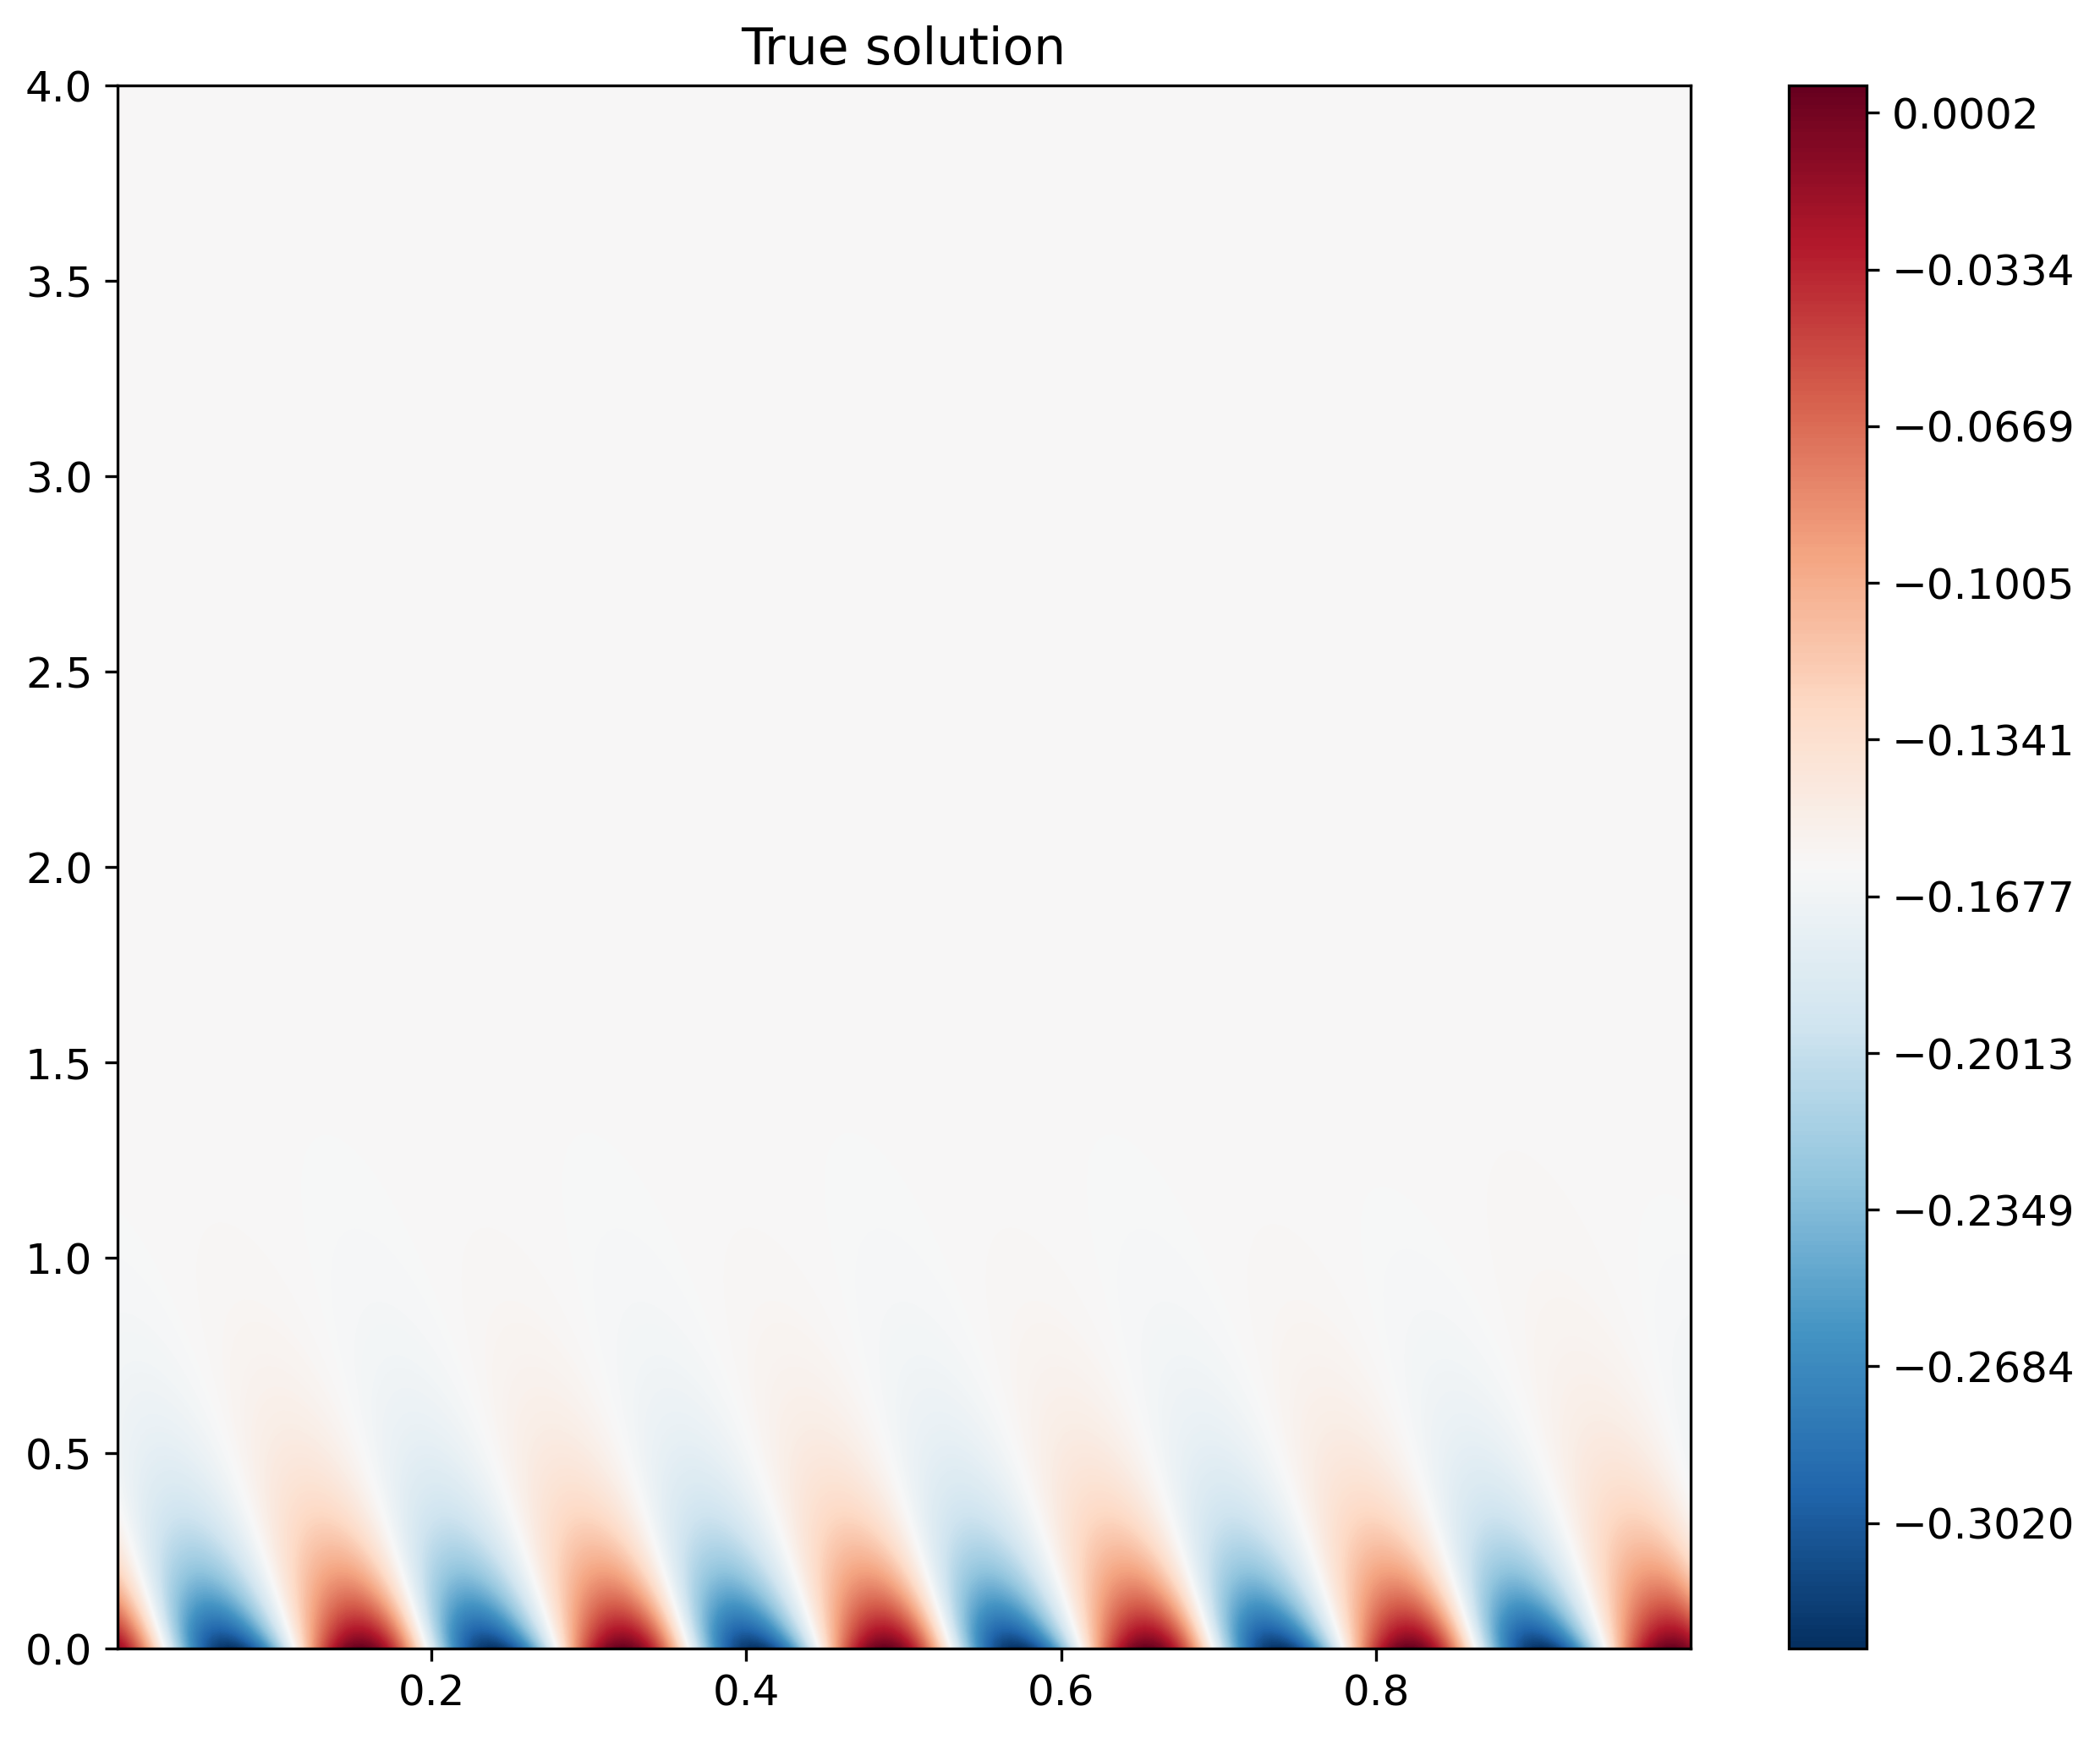

In [55]:
plot_prediction(train_loop, res=200, out_idx=0, t_plot=0.);

In [57]:
train_loop.train()

======= Step 0 - performing active learning with anchor =======
Will select 7000 collocation points.
Will select 1500 points for each of the 2 boundary conditions.
Will select 1000 extra anchors, giving total of 1000 anchors.
======= Done active learning =======


NotImplementedError: jax.experimental.host_callback has been deprecated since March 2024 and is now no longer supported. See https://github.com/jax-ml/jax/issues/20385

In [ ]:
steps = [50000, 100000]
plot_prediction(train_loop=train_loop, step_idxs=steps, out_idx=0, plot_training_data=False);

In [ ]:
os.makedirs('./saved_models', exist_ok=True)

# with open(f'./saved_models/{param_prefix}_partial.pkl', 'wb+') as f:
#     pkl.dump(train_loop.snapshot_data[steps[0]]['params'], f)
    
with open(f'./saved_models/{param_prefix}.pkl', 'wb+') as f:
    pkl.dump(train_loop.snapshot_data[steps[-1]]['params'], f)

### Experiments area


In [ ]:
model_updated, _ = construct_model(
    data_seed=BURGERS_1D_SIMILAR_SEEDS[seed_idx_pair][1],
    num_domain=1000, 
    num_boundary=100, 
    num_initial=100,
    **model_common_params
)

In [ ]:
with open(f'./saved_models/{param_prefix}.pkl', 'rb') as f:
    model_updated.params = pkl.load(f)

In [ ]:
method = 'eig_greedy'
optim = 'adam'


if method == 'eig_greedy':
    al_args = dict(
        num_points_round=100,
        weight_method= "nystrom_wo_N", # possible options are 'none', 'labels', 'eigvals', 'labels_train
        num_candidates_res=500, #300
        num_candidates_bcs=200,
        num_candidates_init=200,
        memory = True, # True to remember old points and add on new ones
        use_init_train_pts = False,
        sampling = 'pseudo', # uniform, pseudo
        min_num_points_bcs=1,
        min_num_points_res=1,
        points_pool_size=5,
    )
    
elif method == 'eig_kmeans':
    al_args = dict(
        num_points_round=100,
        weight_method= "nystrom_wo_N", # possible options are 'none', 'labels', 'eigvals', 'labels_train
        num_candidates_res=500, #300
        num_candidates_bcs=200,
        num_candidates_init=200,
        memory = True, # True to remember old points and add on new ones
        use_init_train_pts = False,
        sampling = 'pseudo', # uniform, pseudo
        min_num_points_bcs=1,
        min_num_points_res=1,
        points_pool_size=5,
    )
    
elif method == 'gd':
    al_args = dict(
        points_pool_size=500,
        num_points_round=200,
        eig_min=0.001, #1e-2
        lr=1e-2,
        train_steps=1000, #1000
        indicator='span',
        compare_mode=True,
        crit='fr', 
        active_eig=50,
        eps=1e-4,
        dist_reg=0.,
    )

else:
    al_args = dict()
    
    
if optim == 'lbfgs':
    optim_args = dict(
        train_steps=500,
        al_every=50,
        select_anchors_every=50,
        snapshot_every=10,
        optim_method='lbfgs', 
        optim_lr=1e-3, 
        optim_args=dict(maxiter=100),
    )

elif optim == 'adam':
    optim_args = dict(
        train_steps=50000,
        al_every=2000,
        select_anchors_every=2000,
        snapshot_every=1000,
        optim_method='adam', 
        optim_lr=1e-4, 
        optim_args=dict(),
    )
    

train_loop = ModifiedTrainLoop(
    model=model_updated, 
    point_selector_method=method,
    point_selector_args=al_args,
    mem_pts_total_budget=200,
    anchor_budget=0,
    autoscale_loss_w_bcs=False,
    ntk_ratio_threshold=1.,
    **optim_args,
)

In [ ]:
plot_prediction(train_loop, res=200, out_idx=0, t_plot=0.);

In [ ]:
train_loop.train()

In [ ]:
fig, _ = train_loop.plot_training_data()
fig

### Visualisation

In [ ]:
# Visualisation

# train_loop.plot_training_data(step_idx=0)
train_loop.plot_losses()

In [ ]:
plot_prediction(train_loop=train_loop, step_idxs=[0, 5000, 10000, 20000], out_idx=1, plot_training_data=True, t_plot=5.);

In [ ]:
plot_error(train_loop=train_loop, step_idxs=steps, out_idx=2, plot_training_data=False);

In [ ]:
plot_residue_loss(train_loop=train_loop, step_idxs=steps, plot_training_data=False);